In [8]:
!pip install transformers

In [9]:
!pip uninstall -y matplotlib
!pip install matplotlib==3.7.3

Found existing installation: matplotlib 3.7.3
Uninstalling matplotlib-3.7.3:
  Successfully uninstalled matplotlib-3.7.3
  Using cached matplotlib-3.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.7 kB)
Using cached matplotlib-3.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)


In [10]:
import time
import random
import pandas as pd
from glob import glob
import argparse
import json
import subprocess
import sys
import os
import tensorflow as tf
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertConfig

In [11]:
# Define the connection between Input data and Label

In [12]:
def select_data_and_label_from_record(record):
    x = {
        "input_ids": record["input_ids"],
        "input_mask": record["input_mask"],
    }
    y = record["label_ids"]

    return (x, y)

In [13]:
def file_based_input_dataset_builder(channel, input_filenames, max_seq_length, is_training, drop_remainder):
    # トレーニング時には並列読み出しとシャッフルを行う。
    # 評価時にはシャッフルは行わず、並列読み出しは効果がない。

    dataset = tf.data.TFRecordDataset(input_filenames)
    dataset = dataset.repeat(100)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
        "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)

    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=8,
            drop_remainder=drop_remainder,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
    )

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42, buffer_size=10, reshuffle_each_iteration=True)

    return dataset

In [14]:
# train_data = "./data-tfrecord/bert-train"
train_data_filenames = "/mnt/train_small_data.tfrecord"
print("train_data_filenames {}".format(train_data_filenames))

train_dataset = file_based_input_dataset_builder(
    channel="train", 
    input_filenames=train_data_filenames, 
    max_seq_length=64, 
    is_training=True, 
    drop_remainder=False
).map(select_data_and_label_from_record)

train_data_filenames /mnt/train_small_data.tfrecord


In [15]:
print(train_dataset)

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_mask': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [16]:
# validation_data = "./data-tfrecord/bert-validation"
validation_data_filenames = "/mnt/validation_small_data.tfrecord"
print("validation_data_filenames {}".format(validation_data_filenames))

validation_dataset = file_based_input_dataset_builder(
    channel="validation",
    input_filenames=validation_data_filenames,
    max_seq_length=64,
    is_training=False,
    drop_remainder=False,
).map(select_data_and_label_from_record)

validation_data_filenames /mnt/validation_small_data.tfrecord


In [17]:
epochs = 1
steps_per_epoch = 1
validation_steps = 1
test_steps = 1
freeze_bert_layer = True
learning_rate = 3e-5
epsilon = 1e-08
max_seq_length = 64

In [18]:
CLASSES = [1, 2, 3, 4, 5]

config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(CLASSES),
    id2label={0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
    label2id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
)
print(config)

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": 1,
    "1": 2,
    "2": 3,
    "3": 4,
    "4": 5
  },
  "initializer_range": 0.02,
  "label2id": {
    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.36.2",
  "vocab_size": 30522
}



In [19]:
# Adding the layer for fine tuning on BERT

In [20]:
transformer_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

input_ids = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype="int32")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_mask", dtype="int32")

embedding_layer = transformer_model.distilbert(input_ids, attention_mask=input_mask)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(
    embedding_layer
)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation="relu")(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(X)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=X)

for layer in model.layers[:3]:
    layer.trainable = not freeze_bert_layer

model.safetensors: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268M/268M [00:02<00:00, 113MB/s]
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification we

In [21]:
# Set up the custom classifier model

In [22]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 input_mask (InputLayer)     [(None, 64)]                 0         []                            
                                                                                                  
 distilbert (TFDistilBertMa  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 inLayer)                    den_state=(None, 64, 768),   0          'input_mask[0][0]']          
                              hidden_states=None, atten                                           
                             tions=None)                                                      

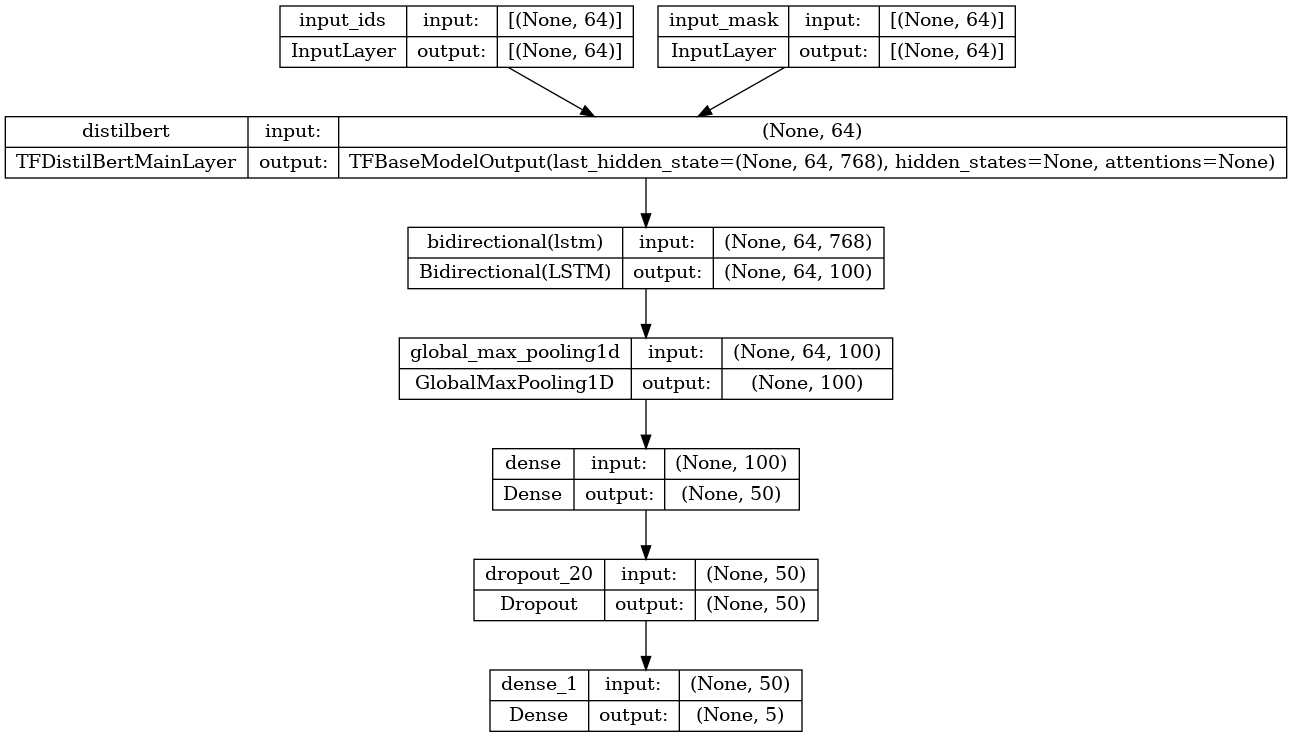

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [24]:
callbacks = []

log_dir = "./tmp/tensorboard/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks.append(tensorboard_callback)

In [25]:
history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-01-15 09:39:34.389814: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdf0422d3d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-15 09:39:34.389862: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P1000, Compute Capability 6.1
2024-01-15 09:39:34.401286: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-15 09:39:34.430572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-01-15 09:39:34.505583: I ./tensorflow/compiler/jit/devic

1/1 [==============================] - 16s 16s/step - loss: 1.7035 - accuracy: 0.1250 - val_loss: 1.8525 - val_accuracy: 0.0000e+00


In [26]:
epochs = 32
steps_per_epoch = 32
validation_steps = 32
test_steps = 32
freeze_bert_layer = True
learning_rate = 3e-5
epsilon = 1e-08
max_seq_length = 64

In [27]:
history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

Epoch 1/32
32/32 [==============================] - 51s 2s/step - loss: 1.6555 - accuracy: 0.1523 - val_loss: 1.6053 - val_accuracy: 0.2109
Epoch 2/32
32/32 [==============================] - 52s 2s/step - loss: 1.6343 - accuracy: 0.1914 - val_loss: 1.5986 - val_accuracy: 0.2383
Epoch 3/32
32/32 [==============================] - 55s 2s/step - loss: 1.6200 - accuracy: 0.2109 - val_loss: 1.5953 - val_accuracy: 0.2266
Epoch 4/32
32/32 [==============================] - 50s 2s/step - loss: 1.6122 - accuracy: 0.1836 - val_loss: 1.5901 - val_accuracy: 0.2852
Epoch 5/32
32/32 [==============================] - 49s 2s/step - loss: 1.6267 - accuracy: 0.1562 - val_loss: 1.5876 - val_accuracy: 0.3164
Epoch 6/32
32/32 [==============================] - 50s 2s/step - loss: 1.5997 - accuracy: 0.2500 - val_loss: 1.5864 - val_accuracy: 0.3047
Epoch 7/32
32/32 [==============================] - 51s 2s/step - loss: 1.6108 - accuracy: 0.2383 - val_loss: 1.5810 - val_accuracy: 0.3125
Epoch 8/32
32/32 [==

In [28]:
print(history.history)

{'loss': [1.6554538011550903, 1.634311556816101, 1.6200294494628906, 1.6121553182601929, 1.6267340183258057, 1.5996508598327637, 1.6107707023620605, 1.6216603517532349, 1.6070867776870728, 1.5778417587280273, 1.5868198871612549, 1.5851329565048218, 1.5991265773773193, 1.5819387435913086, 1.5541046857833862, 1.5652148723602295, 1.586443543434143, 1.5565636157989502, 1.5657705068588257, 1.549609661102295, 1.5522863864898682, 1.534833312034607, 1.5280731916427612, 1.5182944536209106, 1.5291675329208374, 1.551417350769043, 1.5043026208877563, 1.5253416299819946, 1.5612881183624268, 1.538267731666565, 1.4876430034637451, 1.5225342512130737], 'accuracy': [0.15234375, 0.19140625, 0.2109375, 0.18359375, 0.15625, 0.25, 0.23828125, 0.234375, 0.2578125, 0.27734375, 0.26953125, 0.2421875, 0.2265625, 0.23828125, 0.3359375, 0.30859375, 0.2421875, 0.33203125, 0.30859375, 0.3046875, 0.36328125, 0.359375, 0.35546875, 0.35546875, 0.3125, 0.27734375, 0.3828125, 0.32421875, 0.2578125, 0.34375, 0.37890625,

In [29]:
import pandas as pd
import numpy as np

from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def predict(text):
    encode_plus_tokens = tokenizer.encode_plus(
                            text,
                            pad_to_max_length=True,
                            max_length=max_seq_length,
                            truncation=True,
                            return_tensors='tf')
    
    input_ids = encode_plus_tokens['input_ids']
    input_mask = encode_plus_tokens['attention_mask']
    
    outputs = model.predict(x=(input_ids,input_mask))
    
    prediction = [{"label":config.id2label[item.argmax()], \
                   "socre":item.max().item()} for item in outputs]

    return prediction[0]

In [30]:
# Adhoc predict

In [31]:
predict("This is great!")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 2s 2s/step


{'label': 5, 'socre': 0.3986266255378723}

In [32]:
predict("This is cool.")

1/1 [==============================] - 0s 132ms/step


{'label': 5, 'socre': 0.30671918392181396}

In [33]:
predict("I don't like this.")

1/1 [==============================] - 0s 113ms/step


{'label': 1, 'socre': 0.2758525311946869}

In [34]:
predict("I might buy it again.")

1/1 [==============================] - 0s 202ms/step


{'label': 1, 'socre': 0.2253526747226715}

In [35]:
predict("The color is a little bit different from the picture. But it is OK.")

1/1 [==============================] - 0s 165ms/step


{'label': 1, 'socre': 0.26972323656082153}

In [36]:
def plot_accracy(history):
    import matplotlib.pyplot as plt

    # Setting Parameters
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    # 1) Accracy Plt
    plt.plot(epochs, acc, 'bo' ,label = 'training accuracy')
    plt.plot(epochs, val_acc, 'b' , label= 'validation accuracy')
    plt.title('Training and Validation acc')
    plt.legend()

    plt.figure()

    # 2) Loss Plt
    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

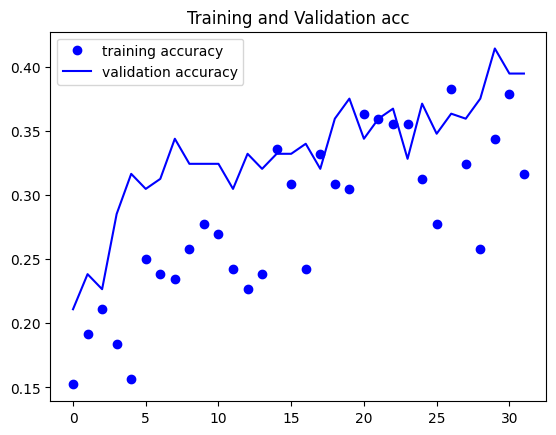

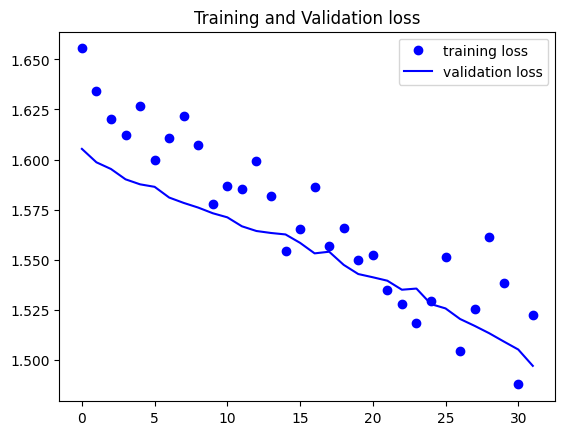

In [37]:
from keras import models 
from keras import layers
from keras import optimizers

#show Accuracy and Loss History
#「loss」と「val_loss」の違いですが、「loss」は学習時のlossの値で、正解と予測の差分です。この値を少なくするように学習を進めます。
#「val_loss」は検証用データでlossを計算した値です。
# モデルは「loss」の値を少なくするように学習データを使用して学習を進めます。ただし学習データのみを使用して学習するため、学習データのみ 
# にあてはまり新たなデータでうまく予測できなくなる、いわゆるオーバーフィッティング状態になることがあります。
# グラフ上では「loss」が下がっていくのに「val_loss」が上がってしまう状態です。
plot_accracy(history)

In [39]:
model.save('/mnt/tensorflow_small/',save_format='tf')

INFO:tensorflow:Assets written to: /mnt/tensorflow_small/assets


INFO:tensorflow:Assets written to: /mnt/tensorflow_small/assets


In [40]:
!ls /mnt/tensorflow_small

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [33]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>